In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../Code/')
from testWN import testWN as twm
from surrogate_model_training_data import get_data

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
from surrogate_model_training_data import get_data

# Get network informations

In [4]:
inp_file = '../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



# Data Pre-Processing

Get clusters:

In [5]:
cluster_labels = pd.read_json('cluster_labels_dt1h.json')
pressure_factor = pd.read_json('pressure_factor_dt1h.json')
n_clusters = 30

Get results:

In [6]:
file = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/results_sim_14.pkl'
with open(file, 'rb') as f:
    results = pickle.load(f)

## Physical preprocessing:

### Junctions
Scale pressure for each node (similar to clustering)

In [7]:
junction_pressure_scaled = results.node['pressure'][node_names[2]]/pressure_factor.to_numpy()

In [8]:
jun_cl_press = junction_pressure_scaled.groupby(cluster_labels.loc['pressure_cluster'], axis=1)
jun_cl_press_mean = jun_cl_press.mean()
jun_cl_press_std = jun_cl_press.std()

jun_cl_demand = results.node['demand'][node_names[2]].groupby(cluster_labels.loc['pressure_cluster'], axis=1)
jun_cl_demand_sum = jun_cl_demand.sum()

jun_cl_qual = results.node['quality'][node_names[2]].diff(axis=0).groupby(cluster_labels.loc['quality'], axis=1)
qual_cl_qual_mean = jun_cl_qual.mean()
qual_cl_qual_std = jun_cl_qual.std()

<IPython.core.display.Javascript object>


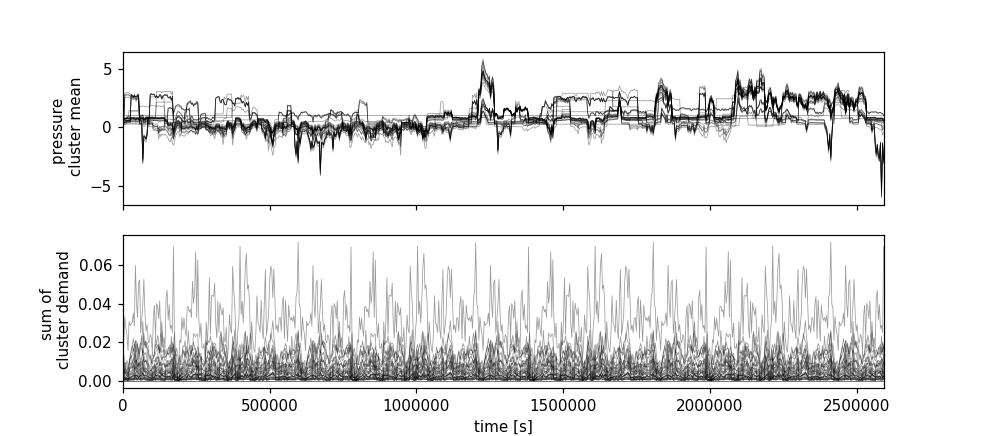

In [9]:
fig, ax = plt.subplots(2,1,figsize=(9,4), sharex=True)
jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
ax[0].set_ylabel('pressure \n cluster mean')


jun_cl_demand_sum.plot(ax=ax[1], legend=False, linewidth=0.5, color='k', alpha=0.4)
ax[1].set_ylabel('sum of \n cluster demand')

ax[1].set_xlabel('time [s]')
plt.show()

Quick validation if everything that flows into/ out of a cluster is in fact equal to the sum of demands within the cluster: 

In [10]:
start_node = nw_link_df.loc['start_node'].apply(lambda x: x.name)
end_node = nw_link_df.loc['end_node'].apply(lambda x: x.name)
flow_out = results.link['flowrate'].copy()
flow_out = flow_out.groupby(start_node, axis=1).sum()
flow_in = results.link['flowrate'].copy()
flow_in = flow_in.groupby(end_node, axis=1).sum()

In [11]:
cluster_in = flow_in.groupby(cluster_labels.loc['pressure_cluster'], axis=1).sum()
cluster_out = flow_out.groupby(cluster_labels.loc['pressure_cluster'], axis=1).sum()

In [12]:
(cluster_in-cluster_out-jun_cl_demand_sum).head(3)

pressure_cluster,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0
0,-1.280569e-09,-6.332994e-08,-4.656613e-09,1.862645e-09,5.029142e-08,-2.328306e-09,-1.862645e-09,-4.656613e-10,-9.313226e-10,-9.313226e-10,...,4.656613e-10,0.0,-3.259629e-09,-1.117587e-08,5.820766e-11,-5.820766e-09,NaN,4.831236e-09,1.234002e-08,-1.164153e-10
3600,-1.746230e-10,-9.313226e-09,4.889444e-09,-3.725290e-09,-1.117587e-08,4.656613e-10,-9.313226e-10,1.164153e-10,4.656613e-10,-2.793968e-09,...,0.000000e+00,0.0,-6.984919e-10,-2.118759e-08,2.328306e-10,-4.132744e-09,NaN,-1.073931e-08,2.607703e-08,3.492460e-10
7200,-2.328306e-10,-1.117587e-08,-3.725290e-09,-9.313226e-10,-3.725290e-09,-1.396984e-09,1.862645e-09,0.000000e+00,6.519258e-09,-3.725290e-09,...,0.000000e+00,0.0,-1.769513e-08,-1.396984e-09,-1.164153e-10,-3.026798e-09,NaN,9.487849e-09,1.653098e-08,2.735178e-07


### Tanks

In [13]:
tank_press = results.node['pressure'][node_names[0]]
# Subtract tank elevation from tank head to obtain tank_level
tank_level = results.node['head'][node_names[0]]-nw_node_df[node_names[0]].loc['elevation']

tank_qual = results.node['quality'][node_names[0]]

<IPython.core.display.Javascript object>


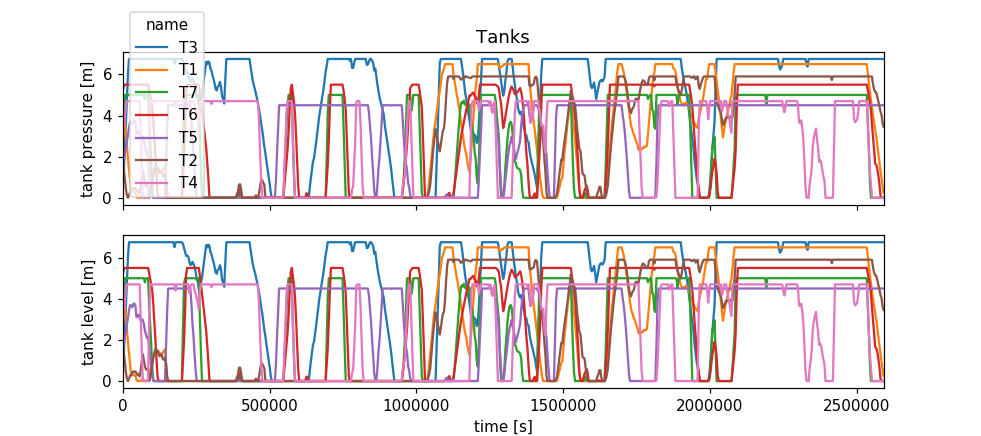

Text(0.5, 0, 'time [s]')

In [14]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(9,4))
tank_press.plot(ax=ax[0])
ax[0].set_title('Tanks')
ax[0].set_ylabel('tank pressure [m]')
tank_level.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')

### Reservoirs

In [15]:
reservoir_press = results.node['pressure'][node_names[1]]
reservoir_level = results.node['head'][node_names[1]]-nw_node_df[node_names[1]].loc['elevation']

reservoir_qual = results.node['quality'][node_names[1]]

<IPython.core.display.Javascript object>


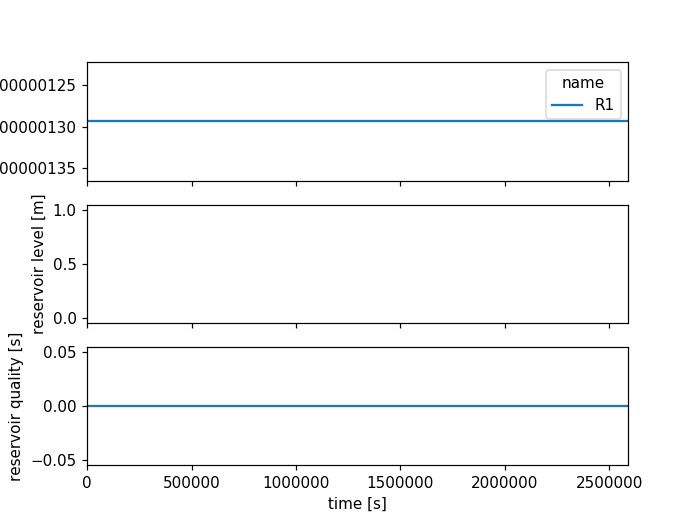

Text(0.5, 0, 'time [s]')

In [16]:
fig, ax = plt.subplots(3,1, sharex=True,)
reservoir_press.plot(ax=ax[0])
ax[0].set_ylabel('reservoir pressure [m]')
reservoir_level.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('reservoir level [m]')
reservoir_qual.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('reservoir quality [s]')
ax[2].set_xlabel('time [s]')

### Pumps

In [17]:
head_pump_speed = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['link_type'] == 'Pump']]
head_pump_status = results.link['status'][nw_link_df.keys()[nw_link_df.loc['link_type'] == 'Pump']]

head_pump_speed_corr = head_pump_speed*head_pump_status

<IPython.core.display.Javascript object>


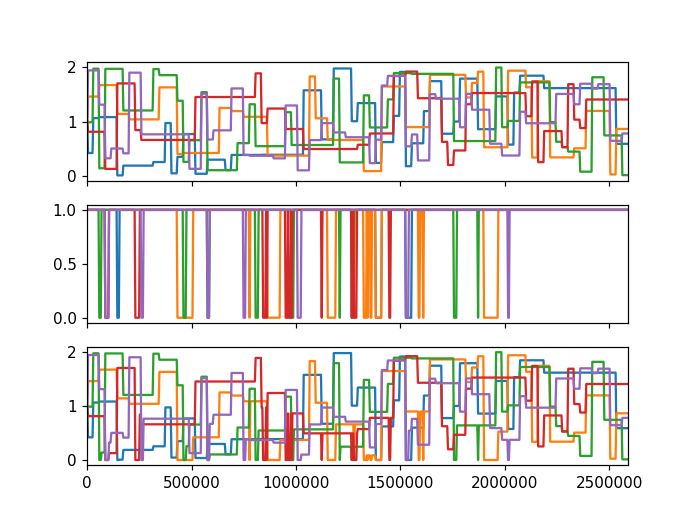

In [18]:
fig, ax = plt.subplots(3,1, sharex=True)
head_pump_speed.plot(ax=ax[0],legend=False)
head_pump_status.plot(ax=ax[1],legend=False)
head_pump_speed_corr.plot(ax=ax[2],legend=False)

In [20]:
pump_energy = economics.pump_energy(results.link['flowrate'], results.node['head'], ctown.wn)[link_names[0]]
pump_energy /= 1000
pump_energy.head(3)

,PU2,PU5,PU6,PU8,PU10
0,60.017796,30.484322,57.840290,30.485120,20.402326
3600,3.685220,91.692606,55.755904,11.097984,105.717288
7200,3.428007,91.825670,55.518343,15.208877,62.572891


<IPython.core.display.Javascript object>


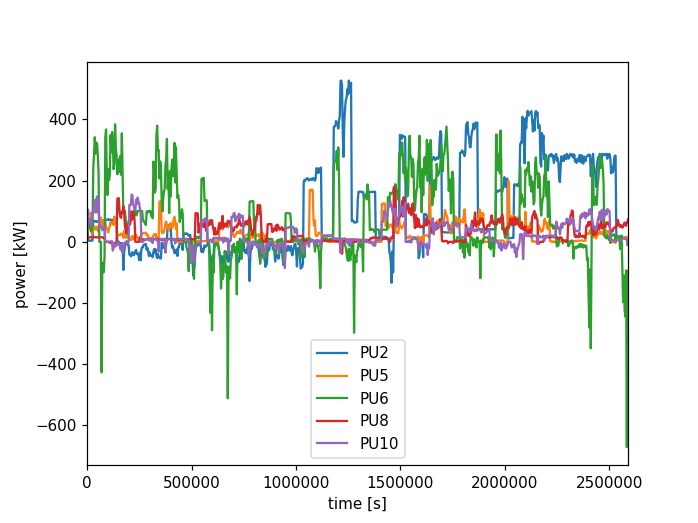

Text(0.5, 0, 'time [s]')

In [21]:
fig, ax = plt.subplots()
pump_energy.plot(ax=ax)
ax.set_ylabel('power [kW]')
ax.set_xlabel('time [s]')

### Valves

In [22]:
PRValve_dp = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'PRV']]
TCValve_throttle = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'TCV']]

PRValve_status = results.link['status'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'PRV']]
TCValve_throttle_status = results.link['status'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'TCV']]

<IPython.core.display.Javascript object>


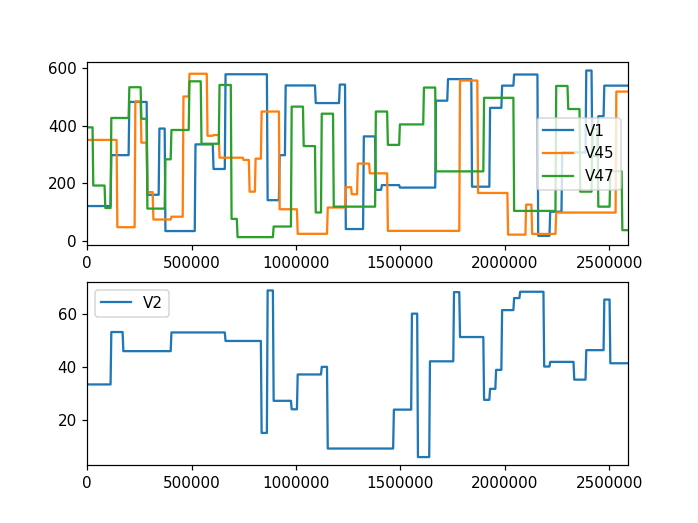

In [23]:
fig, ax = plt.subplots(2)
PRValve_dp.plot(ax=ax[0])
TCValve_throttle.plot(ax=ax[1])

## Neural Network Pre-Processing
### States and Inputs

In [49]:
state_dict = {'jun_cl_press_mean': jun_cl_press_mean,
              # 'jun_cl_press_std': jun_cl_press_std,
              # 'dqual_cl_press_mean': dqual_cl_press_mean,
              # 'dqual_cl_press_std': dqual_cl_press_std,
              'tank_press': tank_press,
              # 'tank_level': tank_level,
              # 'tank_qual': tank_qual,
              # 'reservoir_press': reservoir_press,
              # 'reservoir_level': reservoir_level,
              # 'reservoir_qual': reservoir_qual,
              }

sys_states = pd.concat(state_dict.values(), axis=1, keys=state_dict.keys())


input_dict = {'head_pump_speed': head_pump_speed_corr,
              'PRValve_dp': PRValve_dp,
              'TCValve_throttle': TCValve_throttle,
              'jun_cl_demand_sum': jun_cl_demand_sum}

sys_inputs = pd.concat(input_dict.values(), axis=1, keys=input_dict.keys())

aux_output_dict = {'pump_energy': pump_energy,}

aux_outputs = pd.concat(aux_output_dict.values(), axis=1, keys=aux_output_dict.keys())

### Neural Network I/O

Outputs of the neural network.

Note: we are learning the next state of the system and the current aux_outputs (pump energy)

In [50]:
dsys_states = sys_states.diff(axis=0)
dsys_states_next = dsys_states.shift(-1, axis=0)
sys_states_next = sys_states.shift(-1, axis=0)

nn_output_dict = {'sys_states': dsys_states_next,
                 #'sys_states': sys_states_next,
                 'aux_outputs': aux_outputs
                 }
nn_output = pd.concat(nn_output_dict.values(), axis=1, keys=nn_output_dict.keys())

In [51]:
nn_output.head(3)

sys_states                                                    \
     jun_cl_press_mean                                                     
                     0         1         2         3         4         5   
0            -0.304894 -0.103254 -0.067990  0.104308  0.010744  0.330417   
3600          0.004771  0.005366 -0.018813  2.251847  0.019166  1.699185   
7200          0.000112 -0.000244  0.012120 -0.023727  0.002615 -0.018278   

                                              ...                       \
                                              ... tank_press             
             6         7         8         9  ...         T7        T6   
0    -0.087427 -0.169864  0.006368  0.276340  ...   0.350434  0.256515   
3600  0.017673  0.005684  0.010421  0.002234  ...   1.389357  0.071549   
7200 -0.000564  0.000051  0.004465  0.001923  ...   0.000000  0.000000   

                                   aux_outputs                        \
                                   pump_energy                         
            T5        T2        T4         PU2        PU5        PU6   
0     0.635738 -0.086083 -0.020920   60.017796  30.484322  57.840290   
3600  0.347225 -0.500481  0.388116    3.685220  91.692606  55.755904   
7200  0.164139 -0.499253  0.774827    3.428007  91.825670  55.518343   

                             
                             
            PU8        PU10  
0     30.485120   20.402326  
3600  11.097984  105.717288  
7200  15.208877   62.572891  

[3 rows x 42 columns]

Inputs of the neural network:

In [52]:
nn_input_dict = {'sys_states': sys_states,
                 'sys_inputs': sys_inputs}
nn_input = pd.concat(nn_input_dict.values(), axis=1, keys=nn_input_dict.keys())

print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (721, 76)


NARX model structure?

In [53]:
if True:
    n_arx = 4
    arx_input = []
    for i in range(n_arx):
        arx_input.append(nn_input.shift(i, axis=0))

    arx_input = pd.concat(arx_input, keys=np.arange(n_arx), names=['NARX', 'type', 'name', 'index'], axis=1)
    nn_input = arx_input
print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (721, 304)


In [29]:
nn_input.head(3)

NARX                  0                                                    \
type         sys_states                                                     
name  jun_cl_press_mean                                                     
index                0         1         2         3         4         5    
0              0.706328  0.860382  0.793357  0.397450  0.388645  0.542000   
3600           0.401434  0.757129  0.725367  0.501758  0.399389  0.872418   
7200           0.406205  0.762494  0.706553  2.753605  0.418555  2.571603   

NARX                                           ...                 3          \
type                                           ...        sys_inputs           
name                                           ... jun_cl_demand_sum           
index        6         7         8         9   ...                20  21  22   
0      0.848324  0.741517  0.240554  0.532137  ...               NaN NaN NaN   
3600   0.760898  0.571653  0.246921  0.808477  ...               NaN NaN NaN   
7200   0.778571  0.577337  0.257342  0.810710  ...               NaN NaN NaN   

NARX                               
type                               
name                               
index  23  24  25  26  27  28  29  
0     NaN NaN NaN NaN NaN NaN NaN  
3600  NaN NaN NaN NaN NaN NaN NaN  
7200  NaN NaN NaN NaN NaN NaN NaN  

[3 rows x 304 columns]

Check if NARX structure works:

In [54]:
nn_input.xs(('sys_states',slice(0)),level=('type','index'), axis=1).head(5)

NARX,0,1,2,3
name,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean
0,0.706328,NaN,NaN,NaN
3600,0.401434,0.706328,NaN,NaN
7200,0.406205,0.401434,0.706328,NaN
10800,0.406317,0.406205,0.401434,0.706328
14400,0.408437,0.406317,0.406205,0.401434


Filter inputs and outputs:

In [55]:
# Filter nan:
output_filter = nn_output.isnull().any(axis=1)
if output_filter.any():
    nn_input = nn_input[~output_filter]
    nn_output = nn_output[~output_filter]

input_filter = nn_input.isnull().any(axis=1)
if input_filter.any():
    nn_input = nn_input[~input_filter]
    nn_output = nn_output[~input_filter]

print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (717, 304)


In [56]:
print(nn_input.isnull().any().any())
print(nn_output.isnull().any().any())

False
False


In [57]:
nn_input.xs(('sys_states',slice(0)),level=('type','index'), axis=1).head(3)

NARX,0,1,2,3
name,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean
10800,0.406317,0.406205,0.401434,0.706328
14400,0.408437,0.406317,0.406205,0.401434
18000,0.398951,0.408437,0.406317,0.406205


In [58]:
pd.DataFrame(nn_output['sys_states','jun_cl_press_mean',0]).head(3)

,sys_states
,jun_cl_press_mean
,0
10800,0.002119
14400,-0.009486
18000,-0.003227


### Compare to external output function:

This function is used to create the complete dataset for training.

In [36]:
file_list = ['/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_14_try.pkl',
            #'/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_15_try.pkl',
            #'/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_16_try.pkl',
            #'/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_17_try.pkl'
            ]

nn_input_ext, nn_output_ext = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=True)

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "/home/ffiedler/Documents/git_repos/2019_WNTR_Surrogate_Model/Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



In [37]:
similar_inputs=((nn_input_ext-nn_input)==0).all().all()
print('inputs are identical: {}'.format(similar_inputs))

similar_outputs=((nn_output_ext-nn_output)==0).all().all()
print('outputs are identical: {}'.format(similar_outputs))

inputs are identical: True
outputs are identical: True


### Normalize Data:

In [59]:
input_offset = 0*nn_input.mean()
nn_input_offset = nn_input - input_offset

input_scaling = nn_input_offset.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input_offset/input_scaling

output_offset = 0*nn_output.mean()
nn_output_offset = nn_output - output_offset

output_scaling = nn_output_offset.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output_offset/output_scaling

### Train / Test Splitting

In [60]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input_scaled, nn_output_scaled, test_size=0.2)

In [61]:
X_train.shape

(573, 304)

# Neural Network

## Create Model

In [62]:
n_layer = 3
n_units = 70
l1_regularizer = 0

model_param = {}
model_param['n_in'] = nn_input.shape[1]
model_param['n_out'] = nn_output.shape[1]
model_param['n_units'] = (n_layer)*[n_units]
model_param['activation'] = (n_layer) * ['tanh']

inputs = keras.Input(shape=(model_param['n_in'],))

layer_list = [inputs]


for i in range(len(model_param['n_units'])-1):
    layer_list.append(
        keras.layers.Dense(model_param['n_units'][i],
                           activation=model_param['activation'][i],
                           kernel_regularizer=keras.regularizers.l1(l=l1_regularizer)
                           )(layer_list[i])
    )

outputs = keras.layers.Dense(model_param['n_out'],
                             activation='linear')(layer_list[-1])

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 304)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 70)                21350     
_________________________________________________________________
dense_4 (Dense)              (None, 70)                4970      
_________________________________________________________________
dense_5 (Dense)              (None, 42)                2982      
Total params: 29,302
Trainable params: 29,302
Non-trainable params: 0
_________________________________________________________________


## Train model

In [63]:
optim = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-8, patience=50, mode='min')
model.compile(optimizer=optim,
              loss='mse')

In [64]:
history = model.fit(X_train.to_numpy(), 
                    Y_train.to_numpy(), 
                    batch_size=100, 
                    epochs=2000,
                    validation_data=(X_test.to_numpy(),Y_test.to_numpy()),
                    callbacks=[callback])

Train on 573 samples, validate on 144 samples
Epoch 1/2000
573/573 [==============================] - 1s 1ms/sample - loss: 0.1515 - val_loss: 0.0792
Epoch 2/2000
573/573 [==============================] - 0s 144us/sample - loss: 0.0713 - val_loss: 0.0554
Epoch 3/2000
573/573 [==============================] - 0s 169us/sample - loss: 0.0503 - val_loss: 0.0426
Epoch 4/2000
573/573 [==============================] - 0s 168us/sample - loss: 0.0402 - val_loss: 0.0353
Epoch 5/2000
573/573 [==============================] - 0s 235us/sample - loss: 0.0349 - val_loss: 0.0314
Epoch 6/2000
573/573 [==============================] - 0s 186us/sample - loss: 0.0309 - val_loss: 0.0288
Epoch 7/2000
573/573 [==============================] - 0s 203us/sample - loss: 0.0286 - val_loss: 0.0268
Epoch 8/2000
573/573 [==============================] - 0s 207us/sample - loss: 0.0269 - val_loss: 0.0257
Epoch 9/2000
573/573 [==============================] - 0s 251us/sample - loss: 0.0257 - val_loss: 0.0246
Ep

573/573 [==============================] - 0s 205us/sample - loss: 0.0147 - val_loss: 0.0161
Epoch 78/2000
573/573 [==============================] - 0s 226us/sample - loss: 0.0148 - val_loss: 0.0169
Epoch 79/2000
573/573 [==============================] - 0s 199us/sample - loss: 0.0153 - val_loss: 0.0172
Epoch 80/2000
573/573 [==============================] - 0s 306us/sample - loss: 0.0150 - val_loss: 0.0166
Epoch 81/2000
573/573 [==============================] - 0s 333us/sample - loss: 0.0149 - val_loss: 0.0157
Epoch 82/2000
573/573 [==============================] - 0s 257us/sample - loss: 0.0145 - val_loss: 0.0161
Epoch 83/2000
573/573 [==============================] - 0s 225us/sample - loss: 0.0147 - val_loss: 0.0162
Epoch 84/2000
573/573 [==============================] - 0s 196us/sample - loss: 0.0149 - val_loss: 0.0163
Epoch 85/2000
573/573 [==============================] - 0s 163us/sample - loss: 0.0147 - val_loss: 0.0159
Epoch 86/2000
573/573 [============================

573/573 [==============================] - 0s 174us/sample - loss: 0.0122 - val_loss: 0.0145
Epoch 154/2000
573/573 [==============================] - 0s 146us/sample - loss: 0.0119 - val_loss: 0.0144
Epoch 155/2000
573/573 [==============================] - 0s 155us/sample - loss: 0.0118 - val_loss: 0.0146
Epoch 156/2000
573/573 [==============================] - 0s 277us/sample - loss: 0.0119 - val_loss: 0.0145
Epoch 157/2000
573/573 [==============================] - 0s 204us/sample - loss: 0.0121 - val_loss: 0.0147
Epoch 158/2000
573/573 [==============================] - 0s 176us/sample - loss: 0.0124 - val_loss: 0.0154
Epoch 159/2000
573/573 [==============================] - 0s 173us/sample - loss: 0.0121 - val_loss: 0.0146
Epoch 160/2000
573/573 [==============================] - 0s 192us/sample - loss: 0.0119 - val_loss: 0.0150
Epoch 161/2000
573/573 [==============================] - 0s 175us/sample - loss: 0.0123 - val_loss: 0.0145
Epoch 162/2000
573/573 [===================

Epoch 229/2000
573/573 [==============================] - 0s 174us/sample - loss: 0.0104 - val_loss: 0.0139
Epoch 230/2000
573/573 [==============================] - 0s 126us/sample - loss: 0.0101 - val_loss: 0.0142
Epoch 231/2000
573/573 [==============================] - 0s 152us/sample - loss: 0.0104 - val_loss: 0.0142
Epoch 232/2000
573/573 [==============================] - 0s 168us/sample - loss: 0.0103 - val_loss: 0.0144
Epoch 233/2000
573/573 [==============================] - 0s 196us/sample - loss: 0.0107 - val_loss: 0.0146
Epoch 234/2000
573/573 [==============================] - 0s 193us/sample - loss: 0.0106 - val_loss: 0.0145
Epoch 235/2000
573/573 [==============================] - 0s 189us/sample - loss: 0.0104 - val_loss: 0.0146
Epoch 236/2000
573/573 [==============================] - 0s 181us/sample - loss: 0.0104 - val_loss: 0.0141
Epoch 237/2000
573/573 [==============================] - 0s 205us/sample - loss: 0.0103 - val_loss: 0.0142
Epoch 238/2000
573/573 [====

Epoch 305/2000
573/573 [==============================] - 0s 172us/sample - loss: 0.0095 - val_loss: 0.0145
Epoch 306/2000
573/573 [==============================] - 0s 108us/sample - loss: 0.0095 - val_loss: 0.0155
Epoch 307/2000
573/573 [==============================] - 0s 97us/sample - loss: 0.0096 - val_loss: 0.0144
Epoch 308/2000
573/573 [==============================] - 0s 96us/sample - loss: 0.0092 - val_loss: 0.0151
Epoch 309/2000
573/573 [==============================] - 0s 102us/sample - loss: 0.0094 - val_loss: 0.0158
Epoch 310/2000
573/573 [==============================] - 0s 107us/sample - loss: 0.0092 - val_loss: 0.0144
Epoch 311/2000
573/573 [==============================] - 0s 96us/sample - loss: 0.0090 - val_loss: 0.0143
Epoch 312/2000
573/573 [==============================] - 0s 138us/sample - loss: 0.0089 - val_loss: 0.0140
Epoch 313/2000
573/573 [==============================] - 0s 171us/sample - loss: 0.0089 - val_loss: 0.0153
Epoch 314/2000
573/573 [=======

Epoch 381/2000
573/573 [==============================] - 0s 119us/sample - loss: 0.0078 - val_loss: 0.0140
Epoch 382/2000
573/573 [==============================] - 0s 110us/sample - loss: 0.0082 - val_loss: 0.0140
Epoch 383/2000
573/573 [==============================] - 0s 235us/sample - loss: 0.0080 - val_loss: 0.0144
Epoch 384/2000
573/573 [==============================] - 0s 263us/sample - loss: 0.0078 - val_loss: 0.0143
Epoch 385/2000
573/573 [==============================] - 0s 259us/sample - loss: 0.0078 - val_loss: 0.0143
Epoch 386/2000
573/573 [==============================] - 0s 249us/sample - loss: 0.0083 - val_loss: 0.0140
Epoch 387/2000
573/573 [==============================] - 0s 212us/sample - loss: 0.0082 - val_loss: 0.0155
Epoch 388/2000
573/573 [==============================] - 0s 176us/sample - loss: 0.0087 - val_loss: 0.0154
Epoch 389/2000
573/573 [==============================] - 0s 224us/sample - loss: 0.0085 - val_loss: 0.0148
Epoch 390/2000
573/573 [====

Epoch 457/2000
573/573 [==============================] - 0s 153us/sample - loss: 0.0071 - val_loss: 0.0144
Epoch 458/2000
573/573 [==============================] - 0s 261us/sample - loss: 0.0074 - val_loss: 0.0136
Epoch 459/2000
573/573 [==============================] - 0s 169us/sample - loss: 0.0073 - val_loss: 0.0140
Epoch 460/2000
573/573 [==============================] - 0s 170us/sample - loss: 0.0069 - val_loss: 0.0139
Epoch 461/2000
573/573 [==============================] - 0s 155us/sample - loss: 0.0069 - val_loss: 0.0141
Epoch 462/2000
573/573 [==============================] - 0s 147us/sample - loss: 0.0073 - val_loss: 0.0140
Epoch 463/2000
573/573 [==============================] - 0s 154us/sample - loss: 0.0081 - val_loss: 0.0142
Epoch 464/2000
573/573 [==============================] - 0s 141us/sample - loss: 0.0073 - val_loss: 0.0143
Epoch 465/2000
573/573 [==============================] - 0s 142us/sample - loss: 0.0073 - val_loss: 0.0136
Epoch 466/2000
573/573 [====

Epoch 533/2000
573/573 [==============================] - 0s 140us/sample - loss: 0.0062 - val_loss: 0.0139
Epoch 534/2000
573/573 [==============================] - 0s 145us/sample - loss: 0.0063 - val_loss: 0.0143
Epoch 535/2000
573/573 [==============================] - 0s 168us/sample - loss: 0.0063 - val_loss: 0.0136
Epoch 536/2000
573/573 [==============================] - 0s 257us/sample - loss: 0.0061 - val_loss: 0.0139
Epoch 537/2000
573/573 [==============================] - 0s 153us/sample - loss: 0.0063 - val_loss: 0.0142
Epoch 538/2000
573/573 [==============================] - 0s 162us/sample - loss: 0.0064 - val_loss: 0.0137
Epoch 539/2000
573/573 [==============================] - 0s 152us/sample - loss: 0.0060 - val_loss: 0.0137
Epoch 540/2000
573/573 [==============================] - 0s 185us/sample - loss: 0.0062 - val_loss: 0.0145
Epoch 541/2000
573/573 [==============================] - 0s 153us/sample - loss: 0.0065 - val_loss: 0.0145
Epoch 542/2000
573/573 [====

Epoch 609/2000
573/573 [==============================] - 0s 205us/sample - loss: 0.0056 - val_loss: 0.0141
Epoch 610/2000
573/573 [==============================] - 0s 125us/sample - loss: 0.0057 - val_loss: 0.0139
Epoch 611/2000
573/573 [==============================] - 0s 123us/sample - loss: 0.0055 - val_loss: 0.0140
Epoch 612/2000
573/573 [==============================] - 0s 121us/sample - loss: 0.0056 - val_loss: 0.0138
Epoch 613/2000
573/573 [==============================] - 0s 126us/sample - loss: 0.0056 - val_loss: 0.0140
Epoch 614/2000
573/573 [==============================] - 0s 120us/sample - loss: 0.0055 - val_loss: 0.0139
Epoch 615/2000
573/573 [==============================] - 0s 112us/sample - loss: 0.0055 - val_loss: 0.0142
Epoch 616/2000
573/573 [==============================] - 0s 127us/sample - loss: 0.0056 - val_loss: 0.0138
Epoch 617/2000
573/573 [==============================] - 0s 128us/sample - loss: 0.0059 - val_loss: 0.0141
Epoch 618/2000
573/573 [====

Epoch 685/2000
573/573 [==============================] - 0s 153us/sample - loss: 0.0052 - val_loss: 0.0141
Epoch 686/2000
573/573 [==============================] - 0s 194us/sample - loss: 0.0052 - val_loss: 0.0139
Epoch 687/2000
573/573 [==============================] - 0s 174us/sample - loss: 0.0053 - val_loss: 0.0141
Epoch 688/2000
573/573 [==============================] - 0s 143us/sample - loss: 0.0052 - val_loss: 0.0139
Epoch 689/2000
573/573 [==============================] - 0s 137us/sample - loss: 0.0052 - val_loss: 0.0145
Epoch 690/2000
573/573 [==============================] - 0s 139us/sample - loss: 0.0053 - val_loss: 0.0141
Epoch 691/2000
573/573 [==============================] - 0s 144us/sample - loss: 0.0052 - val_loss: 0.0148
Epoch 692/2000
573/573 [==============================] - 0s 142us/sample - loss: 0.0054 - val_loss: 0.0145
Epoch 693/2000
573/573 [==============================] - 0s 144us/sample - loss: 0.0052 - val_loss: 0.0144
Epoch 694/2000
573/573 [====

Epoch 761/2000
573/573 [==============================] - 0s 146us/sample - loss: 0.0045 - val_loss: 0.0140
Epoch 762/2000
573/573 [==============================] - 0s 141us/sample - loss: 0.0045 - val_loss: 0.0141
Epoch 763/2000
573/573 [==============================] - 0s 158us/sample - loss: 0.0045 - val_loss: 0.0142
Epoch 764/2000
573/573 [==============================] - 0s 140us/sample - loss: 0.0046 - val_loss: 0.0140
Epoch 765/2000
573/573 [==============================] - 0s 221us/sample - loss: 0.0048 - val_loss: 0.0140
Epoch 766/2000
573/573 [==============================] - 0s 208us/sample - loss: 0.0050 - val_loss: 0.0144
Epoch 767/2000
573/573 [==============================] - 0s 191us/sample - loss: 0.0051 - val_loss: 0.0139
Epoch 768/2000
573/573 [==============================] - 0s 192us/sample - loss: 0.0049 - val_loss: 0.0146
Epoch 769/2000
573/573 [==============================] - 0s 171us/sample - loss: 0.0052 - val_loss: 0.0142
Epoch 770/2000
573/573 [====

Epoch 837/2000
573/573 [==============================] - 0s 109us/sample - loss: 0.0045 - val_loss: 0.0144
Epoch 838/2000
573/573 [==============================] - 0s 108us/sample - loss: 0.0044 - val_loss: 0.0158
Epoch 839/2000
573/573 [==============================] - 0s 163us/sample - loss: 0.0048 - val_loss: 0.0145
Epoch 840/2000
573/573 [==============================] - 0s 134us/sample - loss: 0.0045 - val_loss: 0.0147
Epoch 841/2000
573/573 [==============================] - 0s 126us/sample - loss: 0.0044 - val_loss: 0.0150
Epoch 842/2000
573/573 [==============================] - 0s 117us/sample - loss: 0.0045 - val_loss: 0.0144
Epoch 843/2000
573/573 [==============================] - 0s 158us/sample - loss: 0.0044 - val_loss: 0.0145
Epoch 844/2000
573/573 [==============================] - 0s 118us/sample - loss: 0.0043 - val_loss: 0.0146
Epoch 845/2000
573/573 [==============================] - 0s 154us/sample - loss: 0.0042 - val_loss: 0.0146
Epoch 846/2000
573/573 [====

Epoch 913/2000
573/573 [==============================] - 0s 98us/sample - loss: 0.0039 - val_loss: 0.0145
Epoch 914/2000
573/573 [==============================] - 0s 107us/sample - loss: 0.0039 - val_loss: 0.0148
Epoch 915/2000
573/573 [==============================] - 0s 116us/sample - loss: 0.0040 - val_loss: 0.0147
Epoch 916/2000
573/573 [==============================] - 0s 111us/sample - loss: 0.0041 - val_loss: 0.0151
Epoch 917/2000
573/573 [==============================] - 0s 135us/sample - loss: 0.0041 - val_loss: 0.0151
Epoch 918/2000
573/573 [==============================] - 0s 128us/sample - loss: 0.0041 - val_loss: 0.0147
Epoch 919/2000
573/573 [==============================] - 0s 123us/sample - loss: 0.0040 - val_loss: 0.0145
Epoch 920/2000
573/573 [==============================] - 0s 133us/sample - loss: 0.0040 - val_loss: 0.0151
Epoch 921/2000
573/573 [==============================] - 0s 134us/sample - loss: 0.0041 - val_loss: 0.0151
Epoch 922/2000
573/573 [=====

Epoch 989/2000
573/573 [==============================] - 0s 114us/sample - loss: 0.0039 - val_loss: 0.0156
Epoch 990/2000
573/573 [==============================] - 0s 119us/sample - loss: 0.0039 - val_loss: 0.0148
Epoch 991/2000
573/573 [==============================] - 0s 149us/sample - loss: 0.0039 - val_loss: 0.0150
Epoch 992/2000
573/573 [==============================] - 0s 192us/sample - loss: 0.0039 - val_loss: 0.0157
Epoch 993/2000
573/573 [==============================] - 0s 190us/sample - loss: 0.0040 - val_loss: 0.0149
Epoch 994/2000
573/573 [==============================] - 0s 160us/sample - loss: 0.0037 - val_loss: 0.0152
Epoch 995/2000
573/573 [==============================] - 0s 165us/sample - loss: 0.0040 - val_loss: 0.0153
Epoch 996/2000
573/573 [==============================] - 0s 202us/sample - loss: 0.0039 - val_loss: 0.0152
Epoch 997/2000
573/573 [==============================] - 0s 202us/sample - loss: 0.0038 - val_loss: 0.0148
Epoch 998/2000
573/573 [====

573/573 [==============================] - 0s 115us/sample - loss: 0.0036 - val_loss: 0.0151
Epoch 1065/2000
573/573 [==============================] - 0s 118us/sample - loss: 0.0037 - val_loss: 0.0155
Epoch 1066/2000
573/573 [==============================] - 0s 131us/sample - loss: 0.0038 - val_loss: 0.0156
Epoch 1067/2000
573/573 [==============================] - 0s 111us/sample - loss: 0.0038 - val_loss: 0.0157
Epoch 1068/2000
573/573 [==============================] - 0s 142us/sample - loss: 0.0037 - val_loss: 0.0152
Epoch 1069/2000
573/573 [==============================] - 0s 127us/sample - loss: 0.0036 - val_loss: 0.0156
Epoch 1070/2000
573/573 [==============================] - 0s 132us/sample - loss: 0.0035 - val_loss: 0.0151
Epoch 1071/2000
573/573 [==============================] - 0s 129us/sample - loss: 0.0034 - val_loss: 0.0152
Epoch 1072/2000
573/573 [==============================] - 0s 121us/sample - loss: 0.0035 - val_loss: 0.0152
Epoch 1073/2000
573/573 [==========

573/573 [==============================] - 0s 243us/sample - loss: 0.0032 - val_loss: 0.0155
Epoch 1140/2000
573/573 [==============================] - 0s 167us/sample - loss: 0.0032 - val_loss: 0.0154
Epoch 1141/2000
573/573 [==============================] - 0s 148us/sample - loss: 0.0033 - val_loss: 0.0155
Epoch 1142/2000
573/573 [==============================] - 0s 172us/sample - loss: 0.0032 - val_loss: 0.0158
Epoch 1143/2000
573/573 [==============================] - 0s 162us/sample - loss: 0.0034 - val_loss: 0.0157
Epoch 1144/2000
573/573 [==============================] - 0s 180us/sample - loss: 0.0033 - val_loss: 0.0156
Epoch 1145/2000
573/573 [==============================] - 0s 185us/sample - loss: 0.0032 - val_loss: 0.0154
Epoch 1146/2000
573/573 [==============================] - 0s 144us/sample - loss: 0.0032 - val_loss: 0.0154
Epoch 1147/2000
573/573 [==============================] - 0s 166us/sample - loss: 0.0033 - val_loss: 0.0155
Epoch 1148/2000
573/573 [==========

573/573 [==============================] - 0s 125us/sample - loss: 0.0033 - val_loss: 0.0159
Epoch 1215/2000
573/573 [==============================] - 0s 121us/sample - loss: 0.0030 - val_loss: 0.0156
Epoch 1216/2000
573/573 [==============================] - 0s 123us/sample - loss: 0.0029 - val_loss: 0.0158
Epoch 1217/2000
573/573 [==============================] - 0s 116us/sample - loss: 0.0030 - val_loss: 0.0158
Epoch 1218/2000
573/573 [==============================] - 0s 113us/sample - loss: 0.0032 - val_loss: 0.0158
Epoch 1219/2000
573/573 [==============================] - 0s 125us/sample - loss: 0.0032 - val_loss: 0.0159
Epoch 1220/2000
573/573 [==============================] - 0s 118us/sample - loss: 0.0032 - val_loss: 0.0155
Epoch 1221/2000
573/573 [==============================] - 0s 120us/sample - loss: 0.0030 - val_loss: 0.0159
Epoch 1222/2000
573/573 [==============================] - 0s 113us/sample - loss: 0.0030 - val_loss: 0.0155
Epoch 1223/2000
573/573 [==========

573/573 [==============================] - 0s 170us/sample - loss: 0.0035 - val_loss: 0.0166
Epoch 1290/2000
573/573 [==============================] - 0s 198us/sample - loss: 0.0035 - val_loss: 0.0158
Epoch 1291/2000
573/573 [==============================] - 0s 134us/sample - loss: 0.0032 - val_loss: 0.0163
Epoch 1292/2000
573/573 [==============================] - 0s 110us/sample - loss: 0.0031 - val_loss: 0.0158
Epoch 1293/2000
573/573 [==============================] - 0s 111us/sample - loss: 0.0030 - val_loss: 0.0162
Epoch 1294/2000
573/573 [==============================] - 0s 113us/sample - loss: 0.0030 - val_loss: 0.0160
Epoch 1295/2000
573/573 [==============================] - 0s 150us/sample - loss: 0.0028 - val_loss: 0.0159
Epoch 1296/2000
573/573 [==============================] - 0s 98us/sample - loss: 0.0028 - val_loss: 0.0160
Epoch 1297/2000
573/573 [==============================] - 0s 97us/sample - loss: 0.0029 - val_loss: 0.0161
Epoch 1298/2000
573/573 [============

573/573 [==============================] - 0s 175us/sample - loss: 0.0028 - val_loss: 0.0162
Epoch 1365/2000
573/573 [==============================] - 0s 230us/sample - loss: 0.0027 - val_loss: 0.0162
Epoch 1366/2000
573/573 [==============================] - 0s 264us/sample - loss: 0.0027 - val_loss: 0.0161
Epoch 1367/2000
573/573 [==============================] - 0s 217us/sample - loss: 0.0028 - val_loss: 0.0162
Epoch 1368/2000
573/573 [==============================] - 0s 160us/sample - loss: 0.0030 - val_loss: 0.0165
Epoch 1369/2000
573/573 [==============================] - 0s 163us/sample - loss: 0.0027 - val_loss: 0.0161
Epoch 1370/2000
573/573 [==============================] - 0s 125us/sample - loss: 0.0027 - val_loss: 0.0164
Epoch 1371/2000
573/573 [==============================] - 0s 150us/sample - loss: 0.0031 - val_loss: 0.0166
Epoch 1372/2000
573/573 [==============================] - 0s 218us/sample - loss: 0.0032 - val_loss: 0.0170
Epoch 1373/2000
573/573 [==========

## Evaluate model

In [65]:
class narx_simulator:
    def __init__(self, model, n_arx, input_scaling, output_scaling, input_offset, output_offset, x0, u0, t0):
        self.model = model
        self.n_arx = n_arx
        
        self.input_scaling = input_scaling.to_numpy().reshape(1,-1)
        self.output_scaling = output_scaling.to_numpy().reshape(1,-1)
        self.input_offset = input_offset.to_numpy().reshape(1,-1)
        self.output_offset = output_offset.to_numpy().reshape(1,-1)
        
        self.x = x0
        self.u = u0
        
        assert self.x.shape[0] == n_arx
        assert self.u.shape[0] == n_arx-1
        
        self.t = np.array([t0]).reshape(-1,1)
        self.dt = 3600
            
    def eval_nn(self):
        # Scale input:
        self.nn_in = np.concatenate(((np.flip(self.x[-self.n_arx:,:],axis=0), np.flip(self.u[-self.n_arx:,:], axis=0))),axis=1).reshape(1,-1)
        self.nn_in_scaled = (self.nn_in-self.input_offset)/self.input_scaling
        # Evaluate NN:
        self.nn_out_scaled = self.model.predict(self.nn_in_scaled)
        # Scale output:
        self.nn_out = self.nn_out_scaled*self.output_scaling+self.output_offset
        
        self.x = np.append(self.x, self.x[[-1],:]+self.nn_out[:,:self.x.shape[1]], axis=0)
        self.t = np.append(self.t, np.copy(self.t)[[-1]]+self.dt, axis=0)
        
        
    def next_step(self, sys_inputs_now):
        self.u = np.append(self.u, sys_inputs_now.reshape(1,-1), axis=0)
        
        self.eval_nn()
        
        

In [66]:
x0 = sys_states.head(n_arx).to_numpy()
u0 = sys_inputs.head(n_arx-1).to_numpy()
t0 = sys_states.head(n_arx).index.to_numpy()

nsim = narx_simulator(model, n_arx, input_scaling, output_scaling, input_offset, output_offset, x0, u0, t0)

In [67]:
for k in range(100):
    print(k)
    sys_inputs_now = sys_inputs.iloc[n_arx+1+k].to_numpy()
    nsim.next_step(sys_inputs_now)
sim_res = pd.DataFrame(nsim.x, columns=sys_states.columns, index=nsim.t)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<IPython.core.display.Javascript object>


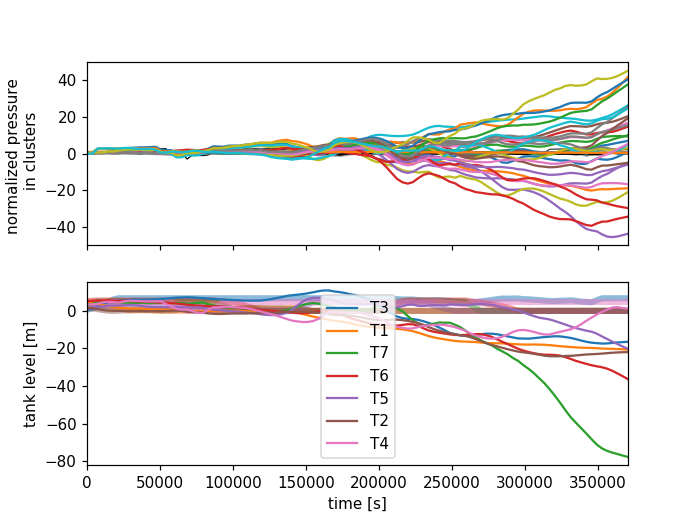

Text(0.5, 0, 'time [s]')

In [74]:
fig, ax = plt.subplots(2,1, sharex=True)

jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_res['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

tank_press.plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res['tank_press'].plot(ax=ax[1])

ax[0].set_xlim(0, sim_res.index.max())

ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')

# Linear Model

In [45]:
linear_reg = LinearRegression().fit(nn_input_scaled.to_numpy(), nn_output_scaled.to_numpy())

In [46]:
x0 = sys_states.head(n_arx).to_numpy()
u0 = sys_inputs.head(n_arx-1).to_numpy()
t0 = sys_states.head(n_arx).index.to_numpy()

nsim_lin = narx_simulator(linear_reg, n_arx, input_scaling, output_scaling, input_offset, output_offset, x0, u0, t0)

In [47]:
for k in range(100):
    print(k)
    sys_inputs_now = sys_inputs.iloc[n_arx+1+k].to_numpy()
    nsim_lin.next_step(sys_inputs_now)
sim_res_lin = pd.DataFrame(nsim_lin.x, columns=sys_states.columns, index=nsim_lin.t)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<IPython.core.display.Javascript object>


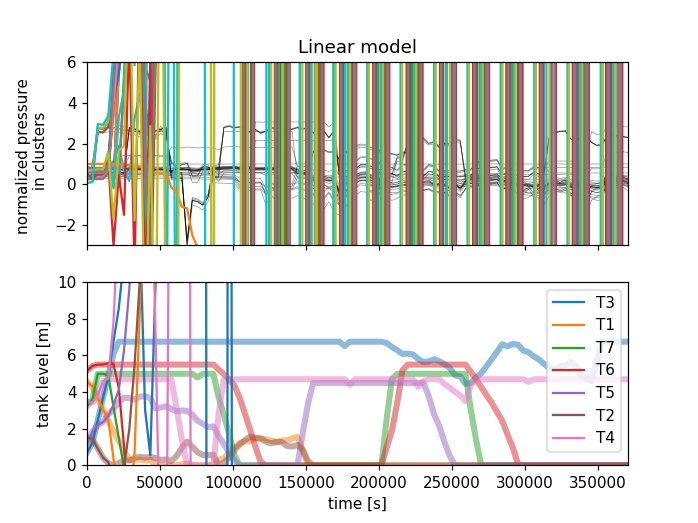

(0, 10)

In [48]:
fig, ax = plt.subplots(2,1, sharex=True)

jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_res_lin['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

tank_press.plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res_lin['tank_press'].plot(ax=ax[1])

ax[0].set_title('Linear model')
ax[0].set_xlim(0, sim_res_lin.index.max())
ax[0].set_ylim(-3, 6)

ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')

ax[1].set_ylim(0, 10)

# Create full training data set:

In [96]:
def scale(X, offset=None, scaling=None, scaling_min=1e-5):
    if np.any(offset) and np.any(scaling):
        X = (X-offset)/scaling
    else:
        offset = X.mean()
        X = X-offset
        scaling = X.abs().max()
        scaling.loc[scaling.abs()<scaling_min] = scaling_min
        X = X/scaling
    return X, offset, scaling

## Load data

In [98]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

In [99]:
nn_input, nn_output = get_data(file_list, 4, cluster_labels, pressure_factor)

In [106]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input, nn_output, test_size=0.2)

In [107]:
X_train, input_offset, input_scaling = scale(X_train)
X_test, _, _ = scale(X_test, input_offset, input_scaling)

Y_train, output_offset, output_scaling = scale(Y_train)
Y_test, _, _ = scale(Y_test, output_offset, output_scaling)

## Save everything

Pack everything needed for training in a .pkl file:

In [108]:
training_dict = {
    'X_train': X_train,
    'X_test': X_test,
    'Y_train': Y_train,
    'Y_test': Y_test,
    'x_offset': input_offset,
    'x_scaling': input_scaling,
    'y_offset': output_offset,
    'y_scaling': output_scaling,
    'cluster_labels': cluster_labels,
    'pressure_factor': pressure_factor
}

with open('02_training_setup_narx4.pkl', 'wb') as f:
    results = pickle.dump(training_dict, f)

# Test external model:

In [109]:
model_path = './models/'
model_name = '000_model_01'
model_ext = keras.models.load_model(model_path+model_name+'.h5')

with open('./training_data/02_training_setup_narx4.pkl', 'rb') as f:
    train_data = pickle.load(f)
    

In [110]:
model_ext.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 304)]             0         
_________________________________________________________________
dense (Dense)                (None, 70)                21350     
_________________________________________________________________
dense_1 (Dense)              (None, 42)                2982      
Total params: 24,332
Trainable params: 24,332
Non-trainable params: 0
_________________________________________________________________


In [111]:
x_scaling = train_data['x_scaling']
y_scaling = train_data['y_scaling']
x_offset = train_data['x_offset']
y_offset = train_data['y_offset']

n_arx = 4

x0 = sys_states.head(n_arx).to_numpy()
u0 = sys_inputs.head(n_arx-1).to_numpy()
t0 = sys_states.head(n_arx).index.to_numpy()

nsim = narx_simulator(model_ext, n_arx, x_scaling, y_scaling, x_offset, y_offset, x0, u0, t0)

In [112]:
for k in range(100):
    sys_inputs_now = sys_inputs.iloc[n_arx+k].to_numpy()
    nsim.next_step(sys_inputs_now)
sim_res = pd.DataFrame(nsim.x, columns=sys_states.columns, index=nsim.t)

<IPython.core.display.Javascript object>


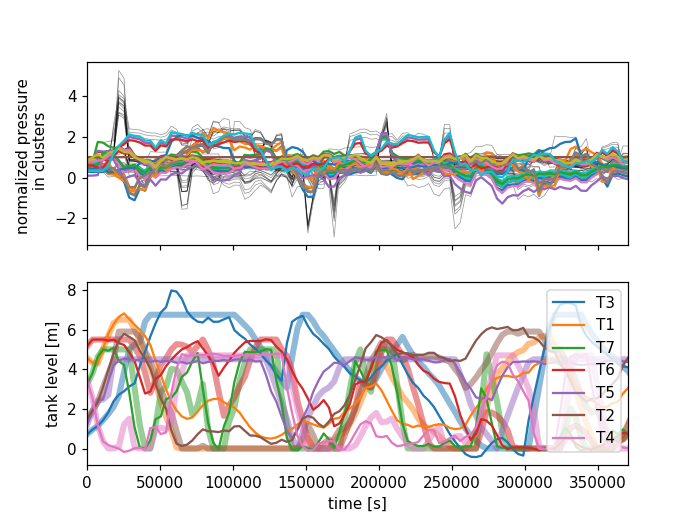

Text(0.5, 0, 'time [s]')

In [113]:
fig, ax = plt.subplots(2,1, sharex=True)

jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_res['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

tank_press.plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res['tank_press'].plot(ax=ax[1])

ax[0].set_xlim(0, sim_res.index.max())

ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')